In [14]:
import numpy as np
import pandas as pd
import os
from scipy.stats import uniform, beta
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from copy import deepcopy
from itertools import product
from sklearn.metrics import mean_absolute_error
from multiprocessing import cpu_count
import networkx as nx

from collections import Counter
from itertools import product
import pickle

from InfluenceDiffusion.Graph import Graph
from InfluenceDiffusion.influence_models import LTM
from InfluenceDiffusion.estimation_models.EMEstimation import LTWeightEstimatorEM
from InfluenceDiffusion.weight_samplers import make_random_weights_with_indeg_constraint

os.chdir("/Users/amkagan/Desktop/gltm_experiments")

from utils.trace_utils import make_report_traces, trace_train_test_split
from utils.utils import make_name_from_dict, RMAE
from utils.model_evaluation_utils import plot_estimator_output_vs_variable

## Define graph range

In [10]:
ps = [0.05, 0.1, 0.2, 0.4, 0.8]
nodes_range = [25, 50, 100, 200, 400]

trace_set_size = 2000

random_state = 1
error_metric = RMAE
fixed_indeg = False
indeg_ub = 1

max_seed_size = 5
n_jobs = cpu_count()
n_trace_sets_per_graph = 5

In [11]:
# max_n_traces = max(trace_set_sizes)

save_dict = {"max_nodes": max(nodes_range), 
             "trace_set_size": trace_set_size,
             "max_seed_size": max_seed_size, 
             "n_trace_sets_per_graph": n_trace_sets_per_graph,
             "max_p": max(ps), 
             "random_state": random_state,
             "fixed_indeg": fixed_indeg,
             "indeg_ub": indeg_ub}

save_name = make_name_from_dict(save_dict)

## Weight & time estimation

In [18]:
from scipy.stats._distn_infrastructure import rv_frozen
from typing import List, Dict


def make_graphs(nodes_range, 
                ps,
                indeg_ub=1,
                directed=True, fixed_indeg=False):
    graphs = {}
    for g_idx, (n_nodes, p) in enumerate(product(nodes_range, ps)):
        g = nx.erdos_renyi_graph(n_nodes, p=p, seed=g_idx, directed=True)
        g = Graph(g.edges)
        if fixed_indeg:
            true_weights = make_random_weights_with_fixed_indeg(g, indeg_ub=indeg_ub)
        else:
             true_weights = make_random_weights_with_indeg_constraint(g, indeg_ub=indeg_ub)
        g.set_weights(true_weights)
        graphs[(n_nodes, p)] = g
    return graphs


def sample_traces_from_graphs(graphs: Dict[tuple, Graph], 
                  n_traces: int, 
                  n_trace_sets_per_graph: int,
                  max_seed_size: int,         
                  report_traces=True):
    
    traces_over_graphs = {}
    seed_size_range = range(1, max_seed_size + 1) 

    for g_key, g in tqdm(graphs.items()):
        traces_over_graphs[g_key] = []
        for _ in range(n_trace_sets_per_graph):
            ltm = LTM(g)
            traces = ltm.sample_traces(n_traces=n_traces, seed_size_range=seed_size_range)
            if report_traces:
                make_report_traces(traces)
            traces_over_graphs[g_key].append(traces)
    return traces_over_graphs
        

In [ ]:
np.random.seed(random_state)

print("Making graphs...")
graphs = make_graphs(nodes_range=nodes_range, 
                     ps=ps,
                     indeg_ub=indeg_ub,
                     fixed_indeg=fixed_indeg)

print("Sampling traces...")
traces_over_graphs = sample_traces_from_graphs(graphs=graphs,
                                               n_traces=trace_set_size,
                                               n_trace_sets_per_graph=n_trace_sets_per_graph, 
                                               max_seed_size=max_seed_size,
                                               report_traces=False)


Making graphs...
Sampling traces...


 80%|██████████████████████████████████▍        | 20/25 [05:38<04:48, 57.60s/it]

In [ ]:
weights_dict = {p: {n_nodes: [] for n_nodes in nodes_range} for p in ps} 
error_dict = {p: {n_nodes: [] for n_nodes in nodes_range} for p in ps} 

print("Estimating weights")
for (n_nodes, p), g in tqdm(graphs.items()):
    for traces in traces_over_graphs[(n_nodes, p)]:
        model = LTWeightEstimatorEM(g, n_jobs=None)
        model.fit(traces, max_iter=100, tol=1e-5)
        weights = model.weights_
                      
        weights_dict[p][n_nodes].append(weights)
        error = error_metric(g.weights, weights)
        error_dict[p][n_nodes].append(error)
    with open(f"saved_results/nodes_density_increase_weights_{save_name}.pkl", "wb") as f:
        pickle.dump(weights_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f"saved_results/nodes_density_increase_errors_dict_{save_name}.pkl", "wb") as f:
        pickle.dump(error_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open(f"saved_results/nodes_density_increase_weights_{save_name}.pkl", "rb") as f:
    weights_dict = pickle.load(f)
with open(f"saved_results/nodes_density_increase_errors_dict_{save_name}.pkl", "rb") as f:
    error_dict = pickle.load(f)

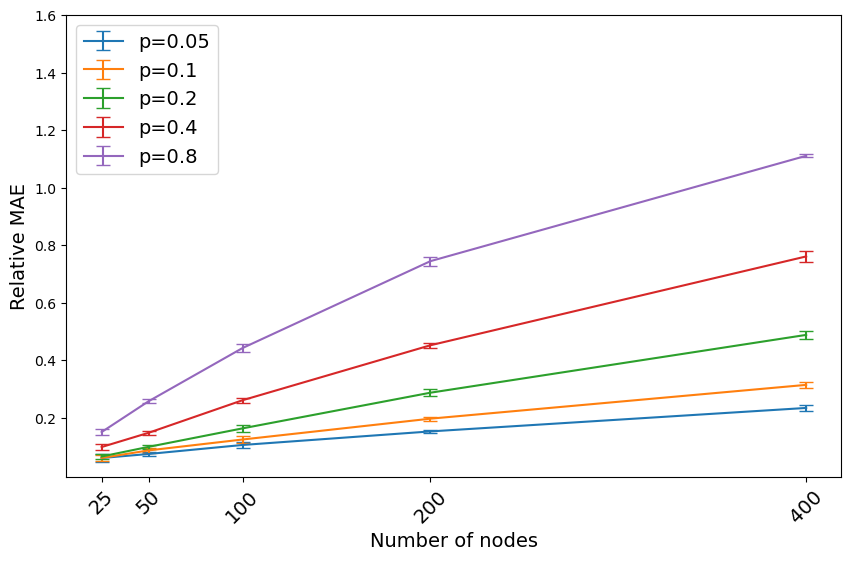

In [6]:
plt.figure(figsize=(10, 6))
for prob, n_nodes_2_errors in error_dict.items():
    errors_array =  np.array(list(n_nodes_2_errors.values()))
    mean_errros = errors_array.mean(1)
    std_errors = errors_array.std(1)
    plt.errorbar(n_nodes_2_errors.keys(), mean_errros, yerr=2 * std_errors, label=f"p={prob}", 
                 capsize=5)
plt.xlabel("Number of nodes", fontsize=14)
plt.ylabel("Relative MAE", fontsize=14)
plt.xticks(nodes_range, label=nodes_range, fontsize=14, rotation=45)
plt.yticks(np.linspace(0.2, 1.6, 8))
plt.legend(fontsize=14)
plt.savefig("figures/er_prob_variation.png", dpi=150, bbox_inches="tight")
plt.show()